1

In [ ]:
import pandas as pd
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# Load CSV file with metadata
csv_file_path = '/content/matched_dataset.csv'
df = pd.read_csv(csv_file_path)

# Handle missing data, age casting to float
df['age'] = pd.to_numeric(df['age'], errors='coerce').fillna(df['age'].mean())  # Replace missing age with mean
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)  # Male=1, Female=0

# Convert "fracture_visible" to binary labels (1 for fracture, 0 for no fracture)
df['fracture_visible'] = df['fracture_visible'].apply(lambda x: 1 if x == 1 else 0)

# Define the folder where the X-ray images are stored
image_folder = '/content/drive/MyDrive/BONE/extracted_images'

# Function to get image file path from filestem
def get_image_path(filestem):
    """Generates the path to the image based on the filestem."""
    return os.path.join(image_folder, f'{filestem}.png')  # Modify extension if necessary

# Load and preprocess the image
def preprocess_image(image_path, img_height=256, img_width=256):
    """Loads and preprocesses the image: resize, normalize, and return as array."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_height, img_width))
    img = img / 255.0  # Normalize pixel values to [0,1]
    return img

# Split data into train and test sets
X = df['filestem'].apply(get_image_path)  # Image paths
y = df['fracture_visible']  # Labels (1 for fracture, 0 for no fracture)

# Add age and gender as additional features
X_additional = df[['age', 'gender']]  # Optional: additional features for advanced modeling

# Split the data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_additional, X_test_additional = train_test_split(X_additional, test_size=0.2, random_state=42)

# Prepare the image data for training and testing
def load_and_preprocess_images(image_paths):
    """Preprocesses all images given a list of paths."""
    images = [preprocess_image(path) for path in image_paths]
    return np.array(images).reshape(-1, 256, 256, 1)  # Adjust shape for grayscale image (H, W, 1)

# Preprocess images for training and testing
X_train_images = load_and_preprocess_images(X_train)
X_test_images = load_and_preprocess_images(X_test)


In [ ]:

# Image Preprocessing: Convert grayscale images to 3-channel (RGB)
def preprocess_image(image_path, img_height=256, img_width=256):
    """Loads and preprocesses the image: resize, convert to 3 channels, normalize, and return as array."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_height, img_width))
    img = np.stack([img] * 3, axis=-1)  # Convert to 3 channels (RGB)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
import cv2
import os

# Image Preprocessing: Convert grayscale images to 3-channel (RGB)
def preprocess_image(image_path, img_height=256, img_width=256):
    """Loads and preprocesses the image: resize, convert to 3 channels, normalize, and return as array."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_height, img_width))
    img = np.stack([img] * 3, axis=-1)  # Convert to 3 channels (RGB)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Data Augmentation to increase dataset variability
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use this data generator in training
train_generator = data_gen.flow([X_train_images, X_train_additional], y_train, batch_size=16)


# EfficientNet-based model with L2 regularization and Dropout
def build_efficientnet_model_with_regularization(input_shape=(256, 256, 3), additional_features_shape=(2,)):
    img_input = Input(shape=input_shape, name='img_input')
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=img_input)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Dense layers with L2 regularization and Dropout
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Additional input for age and gender
    additional_input = Input(shape=additional_features_shape, name='additional_input')
    combined = tf.keras.layers.concatenate([x, additional_input])

    # Output layer (binary classification: fracture or no fracture)
    output = Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))(combined)

    model = Model(inputs=[img_input, additional_input], outputs=output)

    return model

# Build the model
model = build_efficientnet_model_with_regularization()

# Compile the model with weighted binary crossentropy for class imbalance
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)    │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ img_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 256, 256, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,377,766 (16.70 MB)

 Trainable params: 4,335,743 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K

# Custom Dice Coefficient metric
def dice_coefficient(y_true, y_pred, smooth=1):
    """Calculates Dice Coefficient."""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Intersection over Union (IoU) metric
def iou(y_true, y_pred, smooth=1):
    """Calculates Intersection over Union (IoU)."""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Callbacks for early stopping, learning rate reduction, and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
model_checkpoint = ModelCheckpoint('best_fracture_model.keras', save_best_only=True, monitor='val_loss', mode='min')


4

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Add this callback when you train the model
history = model.fit(
    [X_train_images, X_train_additional], y_train,
    validation_data=([X_test_images, X_test_additional], y_test),
    epochs=20, batch_size=16,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 163s 311ms/step - accuracy: 0.7634 - loss: 2.2042 - val_accuracy: 0.6743 - val_loss: 0.7522 - learning_rate: 0.0010
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.8689 - loss: 0.3577 - val_accuracy: 0.6822 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.9146 - loss: 0.2618 - val_accuracy: 0.7905 - val_loss: 0.4235 - learning_rate: 0.0010
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - accuracy: 0.9288 - loss: 0.2366 - val_accuracy: 0.7915 - val_loss: 0.4151 - learning_rate: 0.0010
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - accuracy: 0.9370 - loss: 0.2102 - val_accuracy: 0.8709 - val_loss: 0.3356 - learning_rate: 0.0010
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - accuracy: 0.9434 - loss: 0.1850 - val_accuracy: 0.8848 - val_loss: 0.3019 - learning_rate: 0.0010
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - accuracy: 0.9627 

5

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict using the test data
y_pred = model.predict([X_test_images, X_test_additional])
y_pred_labels = (y_pred > 0.5).astype(int)  # Threshold of 0.5 for binary classification

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step
Precision: 0.9285
Recall: 0.8984
F1-Score: 0.9132


In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming you have true labels and predicted labels
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()

# Calculate specificity
specificity = tn / (tn + fp)

print(f"Specificity: {specificity:.4f}")


Specificity: 0.8567


6

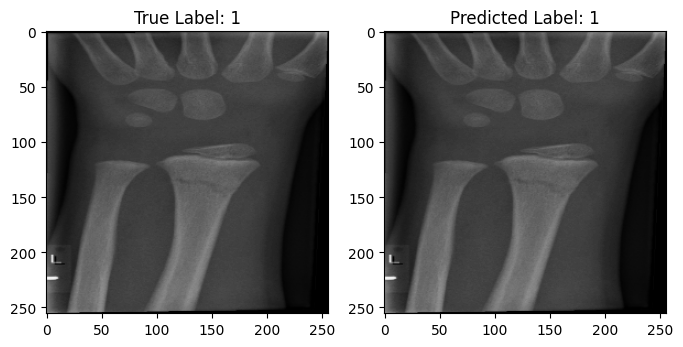

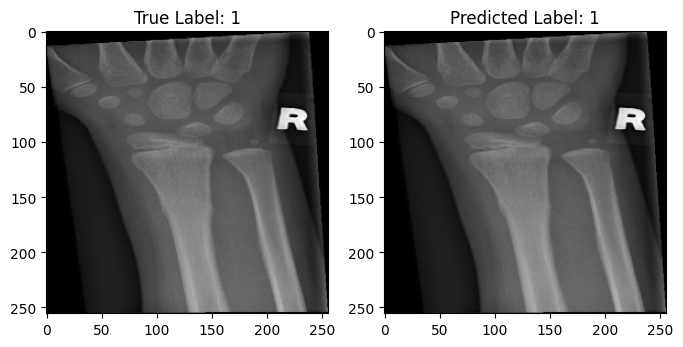

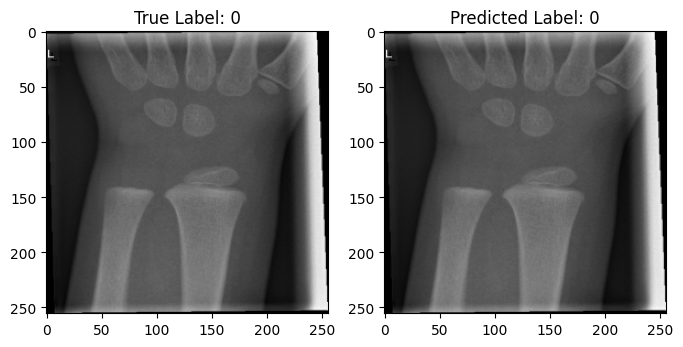

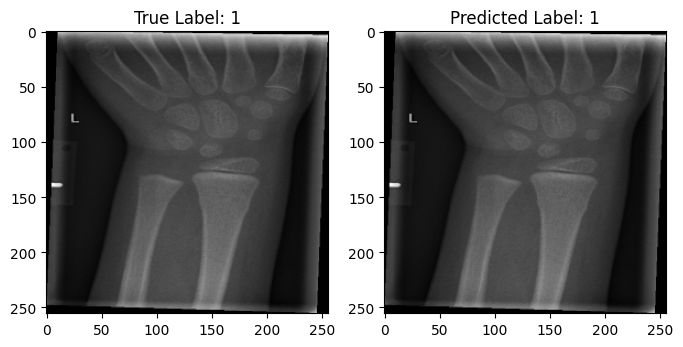

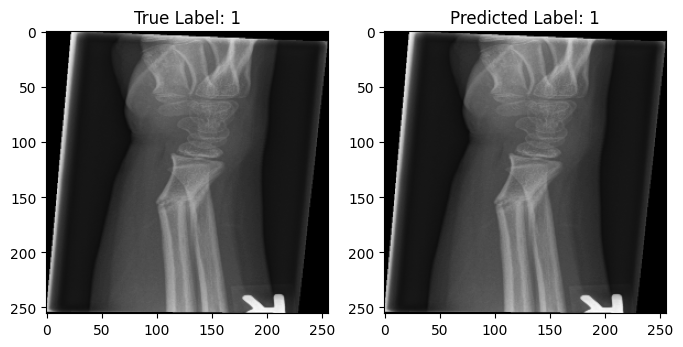

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure data is converted to NumPy arrays
y_test = np.array(y_test)
X_test_images = np.array(X_test_images)
y_pred = np.array(y_pred)

# Visualize some predictions
def plot_predictions(images, true_labels, predictions):
    """Plots predictions and true labels side by side."""
    for i in range(5):
        plt.figure(figsize=(8, 4))

        # Display the X-ray image
        plt.subplot(1, 2, 1)
        plt.imshow(images[i].reshape(256, 256), cmap='gray')
        plt.title(f'True Label: {true_labels[i]}')

        # Display the predicted label
        pred = 1 if predictions[i] > 0.5 else 0  # Threshold for binary classification
        plt.subplot(1, 2, 2)
        plt.imshow(images[i].reshape(256, 256), cmap='gray')
        plt.title(f'Predicted Label: {pred}')

        plt.show()

# Predict using the test data
plot_predictions(X_test_images, y_test, y_pred)


In [ ]:
# Ensure you are using a GPU for faster training
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available.")
else:
    device = torch.device('cpu')
    print("GPU not available, using CPU.")


GPU is available.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Clone the YOLOv5 repository
%cd /content
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install required dependencies
!pip install -r requirements.txt


/content
Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 17022 (delta 122), reused 129 (delta 70), pack-reused 16805 (from 1)
Receiving objects: 100% (17022/17022), 15.75 MiB | 20.31 MiB/s, done.
Resolving deltas: 100% (11655/11655), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 35.8 MB/s eta 0:00:00


In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
images_dir = '/content/drive/MyDrive/BONE/extracted_images'
labels_dir = '/content/drive/MyDrive/BONE/labels'

# Create a new directory for YOLOv5 dataset
dataset_dir = '/content/YOLOv5_dataset'
images_train_dir = os.path.join(dataset_dir, 'images/train')
images_val_dir = os.path.join(dataset_dir, 'images/val')
images_test_dir = os.path.join(dataset_dir, 'images/test')
labels_train_dir = os.path.join(dataset_dir, 'labels/train')
labels_val_dir = os.path.join(dataset_dir, 'labels/val')
labels_test_dir = os.path.join(dataset_dir, 'labels/test')

# Create directories
os.makedirs(images_train_dir, exist_ok=True)
os.makedirs(images_val_dir, exist_ok=True)
os.makedirs(images_test_dir, exist_ok=True)
os.makedirs(labels_train_dir, exist_ok=True)
os.makedirs(labels_val_dir, exist_ok=True)
os.makedirs(labels_test_dir, exist_ok=True)

# Get list of image files
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Split into train, validation, and test sets (70/15/15 split)
train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Function to copy files
def copy_files(file_list, src_images, dst_images, src_labels, dst_labels):
    for file in file_list:
        # Copy image
        shutil.copy(os.path.join(src_images, file), os.path.join(dst_images, file))

        # Corresponding label
        label_file = os.path.splitext(file)[0] + '.txt'
        src_label_path = os.path.join(src_labels, label_file)
        dst_label_path = os.path.join(dst_labels, label_file)

        # Check if label exists
        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dst_label_path)
        else:
            # If no label, create an empty file
            open(dst_label_path, 'a').close()

# Copy training files
copy_files(train_files, images_dir, images_train_dir, labels_dir, labels_train_dir)

# Copy validation files
copy_files(val_files, images_dir, images_val_dir, labels_dir, labels_val_dir)

# Copy test files
copy_files(test_files, images_dir, images_test_dir, labels_dir, labels_test_dir)

print(f"Total training images: {len(os.listdir(images_train_dir))}")
print(f"Total validation images: {len(os.listdir(images_val_dir))}")
print(f"Total test images: {len(os.listdir(images_test_dir))}")


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/BONE/extracted_images'

In [5]:
import yaml

# Define the number of classes and class names
num_classes = 1
class_names = ['fracture_visibile']  # Modify if you have multiple classes

# Create data dictionary
data_dict = {
    'train': os.path.join(dataset_dir, 'images/train'),
    'val': os.path.join(dataset_dir, 'images/val'),
    'nc': num_classes,
    'names': class_names
}

# Save to data.yaml
data_yaml_path = os.path.join('/content/yolov5', 'data.yaml')
with open(data_yaml_path, 'w') as file:
    yaml.dump(data_dict, file)

print(f"data.yaml created at {data_yaml_path}")


data.yaml created at /content/yolov5/data.yaml


In [6]:
# Display the contents of data.yaml
with open(data_yaml_path, 'r') as file:
    print(file.read())


names:
- fracture_visibile
nc: 1
train: /content/YOLOv5_dataset/images/train
val: /content/YOLOv5_dataset/images/val



In [7]:
# Train YOLOv5 model
!python train.py --img 640 --batch 16 --epochs 50 --data /content/yolov5/data.yaml --weights yolov5s.pt --cache


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-10-23 12:27:00.729535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 12:27:01.079698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 12:27:01.167634: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

In [8]:
# Evaluate the trained model
!python val.py --weights /content/yolov5/runs/train/exp/weights/best.pt --data /content/yolov5/data.yaml --img 640


val: data=/content/yolov5/data.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Traceback (most recent call last):
  File "/content/yolov5/val.py", line 604, in <module>
    main(opt)
  File "/content/yolov5/val.py", line 575, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov5/val.py", line 270, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
  File "/content/yolov5/models/common.py", line 489, in __init__
    model =

In [2]:
# Inference on validation images
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source /content/YOLOv5_dataset/images/val --save-txt --save-conf


python3: can't open file '/content/detect.py': [Errno 2] No such file or directory


In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Path to detection results
detect_dir = '/content/yolov5/runs/detect/exp/'

# List of detected images
detected_images = os.listdir(os.path.join(detect_dir, 'labels'))
detected_images = [f.replace('.txt', '.jpg') for f in detected_images]

# Function to display image with bounding boxes
def display_detection(image_path, label_path):
    # Open image
    img = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    # Read label file
    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            class_id, x_center, y_center, width, height, conf = map(float, parts)

            # Convert YOLO format to pixel coordinates
            img_width, img_height = img.size
            box_width = width * img_width
            box_height = height * img_height
            x = (x_center * img_width) - (box_width / 2)
            y = (y_center * img_height) - (box_height / 2)

            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), box_width, box_height, linewidth=2, edgecolor='r', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
            ax.text(x, y, f"Class {int(class_id)}: {conf:.2f}", bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Display first 5 detections
for img_name in detected_images[:5]:
    img_path = os.path.join(detect_dir, 'images', img_name)
    label_path = os.path.join(detect_dir, 'labels', img_name.replace('.jpg', '.txt'))
    display_detection(img_path, label_path)


In [11]:
import os


In [13]:
%matplotlib inline


In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Path to detection results
detect_dir = '/content/yolov5/runs/detect/exp/'

# List of detected images
detected_images = os.listdir(os.path.join(detect_dir, 'labels'))
detected_images = [f.replace('.txt', '.jpg') for f in detected_images]

# Function to display image with bounding boxes
def display_detection(image_path, label_path):
    try:
        # Open image
        img = Image.open(image_path)
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        ax = plt.gca()

        # Read label file
        with open(label_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                parts = line.strip().split()
                class_id, x_center, y_center, width, height, conf = map(float, parts)

                # Convert YOLO format to pixel coordinates
                img_width, img_height = img.size
                box_width = width * img_width
                box_height = height * img_height
                x = (x_center * img_width) - (box_width / 2)
                y = (y_center * img_height) - (box_height / 2)

                # Create a Rectangle patch
                rect = patches.Rectangle((x, y), box_width, box_height, linewidth=2, edgecolor='r', facecolor='none')

                # Add the patch to the Axes
                ax.add_patch(rect)
                ax.text(x, y, f"Class {int(class_id)}: {conf:.2f}", bbox=dict(facecolor='yellow', alpha=0.5))

        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Display first 5 detections
for img_name in detected_images[:5]:
    img_path = os.path.join(detect_dir, 'images', img_name)
    label_path = os.path.join(detect_dir, 'labels', img_name.replace('.jpg', '.txt'))
    display_detection(img_path, label_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/yolov5/runs/detect/exp/labels'

In [15]:
!ls /content/yolov5/runs/detect/exp/images
!ls /content/yolov5/runs/detect/exp/labels


ls: cannot access '/content/yolov5/runs/detect/exp/images': No such file or directory


In [1]:
for img_name in detected_images[:5]:
    img_path = os.path.join(detect_dir, 'images', img_name)
    label_path = os.path.join(detect_dir, 'labels', img_name.replace('.jpg', '.txt'))

    print(f"Processing {img_path} with label {label_path}")  # Add this line
    display_detection(img_path, label_path)


NameError: name 'detected_images' is not defined

7

2

3

In [1]:
# Ensure you are using a GPU for faster training
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available.")
else:
    device = torch.device('cpu')
    print("GPU not available, using CPU.")


GPU not available, using CPU.


In [2]:
# Clone the YOLOv5 repository
%cd /content
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install required dependencies
!pip install -r requirements.txt


c:\content
c:\content\yolov5


Cloning into 'yolov5'...


Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
images_dir = "C:/Users/santh/Downloads/extracted_images"
labels_dir = 'C:/Users/santh/Downloads/bone fracture/yolo/labels'

# Create a new directory for YOLOv5 dataset
dataset_dir = '/content/santh/downloads/YOLOv5_datasets'
images_train_dir = os.path.join(dataset_dir, 'images/train')
images_val_dir = os.path.join(dataset_dir, 'images/val')
images_test_dir = os.path.join(dataset_dir, 'images/test')
labels_train_dir = os.path.join(dataset_dir, 'labels/train')
labels_val_dir = os.path.join(dataset_dir, 'labels/val')
labels_test_dir = os.path.join(dataset_dir, 'labels/test')

# Create directories
os.makedirs(images_train_dir, exist_ok=True)
os.makedirs(images_val_dir, exist_ok=True)
os.makedirs(images_test_dir, exist_ok=True)
os.makedirs(labels_train_dir, exist_ok=True)
os.makedirs(labels_val_dir, exist_ok=True)
os.makedirs(labels_test_dir, exist_ok=True)

# Get list of image files
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Split into train, validation, and test sets (70/15/15 split)
train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Function to copy files
def copy_files(file_list, src_images, dst_images, src_labels, dst_labels):
    for file in file_list:
        # Copy image
        shutil.copy(os.path.join(src_images, file), os.path.join(dst_images, file))

        # Corresponding label
        label_file = os.path.splitext(file)[0] + '.txt'
        src_label_path = os.path.join(src_labels, label_file)
        dst_label_path = os.path.join(dst_labels, label_file)

        # Check if label exists
        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dst_label_path)
        else:
            # If no label, create an empty file
            open(dst_label_path, 'a').close()

# Copy training files
copy_files(train_files, images_dir, images_train_dir, labels_dir, labels_train_dir)

# Copy validation files
copy_files(val_files, images_dir, images_val_dir, labels_dir, labels_val_dir)

# Copy test files
copy_files(test_files, images_dir, images_test_dir, labels_dir, labels_test_dir)

print(f"Total training images: {len(os.listdir(images_train_dir))}")
print(f"Total validation images: {len(os.listdir(images_val_dir))}")
print(f"Total test images: {len(os.listdir(images_test_dir))}")


Total training images: 3521
Total validation images: 755
Total test images: 755


In [5]:
import os

# Define the directory containing your label files
labels_dir = 'C:/Users/santh/Downloads/bone fracture/yolo/labels'

# Create a set to hold unique class indices
unique_classes = set()

# Loop through each label file in the directory
for label_file in os.listdir(labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f.readlines():
                # Extract the class index (the first value in each line)
                class_index = int(line.split()[0])
                unique_classes.add(class_index)

# Print the unique class indices
print(f"Unique class indices found: {unique_classes}")
print(f"Number of classes: {len(unique_classes)}")


Unique class indices found: {0, 1, 2, 3, 4, 5, 6, 7, 8}
Number of classes: 9


In [7]:
# Define the content for the YAML configuration file
yaml_content = """
path: /content/santh/downloads/YOLOv5_datasets
train: /content/santh/downloads/YOLOv5_datasets/images/train
val: /content/santh/downloads/YOLOv5_datasets/images/val
test: /content/santh/downloads/YOLOv5_datasets/images/test

# Number of classes
nc: 9

# Class names
names:
  - boneanomaly
  - bonelesion
  - foreignbody
  - fracture
  - metal
  - periostealreaction
  - pronatorsign
  - softtissue
  - text
"""

# Save the YAML file
with open('/content/santh/downloads/bone_fracture.yaml', 'w') as f:
    f.write(yaml_content)

print("YAML configuration file created successfully.")


YAML configuration file created successfully.


In [8]:
!pip install ultralytics


Defaulting to user installation because normal site-packages is not writeable


In [10]:
# Clone the YOLOv5 repository (only if you haven't cloned it before)
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install YOLOv5 requirements
!pip install -r requirements.txt


c:\content\yolov5\yolov5


Cloning into 'yolov5'...


Defaulting to user installation because normal site-packages is not writeable


In [9]:
# Define the content for the YAML configuration file
yaml_content = """
path: /content/santh/downloads/YOLOv5_datasets
train: /content/santh/downloads/YOLOv5_datasets/images/train
val: /content/santh/downloads/YOLOv5_datasets/images/val
test: /content/santh/downloads/YOLOv5_datasets/images/test

# Number of classes
nc: 9

# Class names
names:
  - boneanomaly
  - bonelesion
  - foreignbody
  - fracture
  - metal
  - periostealreaction
  - pronatorsign
  - softtissue
  - text
"""

# Save the YAML file
with open('c:/Users/santh/Downloads/bone_fracture/yolov5/done.yaml', 'w') as f:
    f.write(yaml_content)

print("YAML configuration file created successfully.")


YAML configuration file created successfully.


In [17]:
!pip install -U -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for gitpython>=3.1.30 from https://files.pythonhosted.org/packages/e9/bd/cc3a402a6439c15c3d4294333e13042b915bbeab54edc457c723931fed3f/GitPython-3.1.43-py3-none-any.whl.metadata
  Obtaining dependency information for matplotlib>=3.3 from https://files.pythonhosted.org/packages/8b/ce/15b0bb2fb29b3d46211d8ca740b96b5232499fc49200b58b8d571292c9a6/matplotlib-3.9.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for numpy>=1.23.5 from https://files.pythonhosted.org/packages/d4/96/450054662295125af861d48d2c4bc081dadcf1974a879b2104613157aa62/numpy-2.1.2-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/59.7 kB ? eta -:--:--
     -------------------- ------------------- 30.7/59.7 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 59.7/59.7 kB 785.8 kB/s eta 0:00:00
  Obtaining dependency information for psutil f

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.7.4 requires pydantic!=1.8,!=1.8.1,<3.0.0,>=1.7.4, which is not installed.
thinc 8.2.3 requires pydantic!=1.8,!=1.8.1,<3.0.0,>=1.7.4, which is not installed.
conda-repo-cli 1.0.41 requires requests_mock, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
transformers 2.1.1 requires sentencepiece, which is not installed.
streamlit 1.32.1 requires numpy<2,>=1.19.3, but you have numpy 2.1.2 which is incompatible.
streamlit 1.32.1 requires pillow<11,>=7.1.0, but you have pillow 11.0.0 wh

In [2]:
pip install numpy==1.24.4


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for numpy==1.24.4 from https://files.pythonhosted.org/packages/d8/ec/ebef2f7d7c28503f958f0f8b992e7ce606fb74f9e891199329d5f5f87404/numpy-1.24.4-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.8 MB 1.3 MB/s eta 0:00:12
   ---------------------------------------- 0.1/14.8 MB 1.1 MB/s eta 0:00:14
   ---------------------------------------- 0.1/14.8 MB 1.1 MB/s eta 0:00:14
   ---------------------------------------- 0.1/14.8 MB 1.1 MB/s eta 0:00:14
   ---------------------------------------- 0.1/14.8 MB 1.1 MB/s eta 0:00:14
   ---------------------------------------- 0.1/14.8 MB 1.1 MB/s eta 0:00:14
   ---------------------------------------- 0.1/14.8 MB 379.3 kB/s eta 0:00:39
    --------------------------------------- 0.2/14.8 MB 535.8 kB/s eta 0:00:28
    ---------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.7.4 requires pydantic!=1.8,!=1.8.1,<3.0.0,>=1.7.4, which is not installed.
thinc 8.2.3 requires pydantic!=1.8,!=1.8.1,<3.0.0,>=1.7.4, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
transformers 2.1.1 requires sentencepiece, which is not installed.
streamlit 1.32.1 requires pillow<11,>=7.1.0, but you have pillow 11.0.0 which is incompatible.


In [3]:
pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
!python train.py --img 640 --batch 16 --epochs 60 --data 'C:/Users/santh/Downloads/YOLOv5_dataset/Bone.yaml' --weights yolov5s.pt --name bone_fracture_model


python: can't open file 'c:\\Users\\santh\\Downloads\\bone_fracture\\train.py': [Errno 2] No such file or directory


In [10]:
# Move to the yolov5 directory if you aren't already
%cd yolov5

# Run training
!python train.py --img 640 --batch 16 --epochs 60 --data 'c:/Users/santh/Downloads/bone_fracture/yolov5/done.yaml' --weights yolov5s.pt --name bone_fracture_model


[WinError 2] The system cannot find the file specified: 'yolov5'
c:\Users\santh\Downloads\bone_fracture\yolov5


C:\Users\santh\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
train: weights=yolov5s.pt, cfg=, data='c:/Users/santh/Downloads/bone_fracture/yolov5/done.yaml', hyp=data\hyps\hyp.scratch-low.yaml, epochs=60, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=bone_fracture_model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https

In [19]:
# Define the content for the YAML configuration file
yaml_content = """
path: /content/santh/downloads/YOLOv7_datasets
train: /content/santh/downloads/YOLOv7_datasets/images/train
val: /content/santh/downloads/YOLOv7_datasets/images/val
test: /content/santh/downloads/YOLOv7_datasets/images/test

# Number of classes
nc: 9

# Class names
names:
  - boneanomaly
  - bonelesion
  - foreignbody
  - fracture
  - metal
  - periostealreaction
  - pronatorsign
  - softtissue
  - text
"""

# Save the YAML file
with open('/content/santh/downloads/bone_fracture.yaml', 'w') as f:
    f.write(yaml_content)


In [23]:
# Install YOLOv7 dependencies
!pip install -U -r '/content/santh/downloads/yolov7/requirements.txt'  # Adjust the path if needed


Defaulting to user installation because normal site-packages is not writeable


ERROR: Invalid requirement: '#'


In [24]:
# Move to the yolov7 directory
%cd /content/santh/downloads/yolov7  # Adjust the path as necessary


[WinError 2] The system cannot find the file specified: '/content/santh/downloads/yolov7 # Adjust the path as necessary'
c:\content\yolov5\yolov5
